In [29]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import poisson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib.gridspec as gridspec
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.special import gammaln
from numpy.polynomial.laguerre import laggauss

from tqdm.autonotebook import tqdm

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000


## Generate the synthetic data

---

lambda and p_zero

In [30]:
class insilico_experiment:
    def __init__(
        self,
        kill_lambda: float = 3.0,
        p_zero: float = 0.1, # propotion: should be between 0 and 1
        Num_killers_obs: int = 300,
        random_seed: int = 66
    ):
        self.kill_lambda = kill_lambda
        self.p_zero = p_zero
        self.Num_killers_obs = Num_killers_obs
        self.random_seed = random_seed
        
        self.lambdas, self.kills = self._generate_data()
    
    def _generate_data(self):
        rng = np.random.default_rng(self.random_seed)
        is_zero_killer = rng.random(self.Num_killers_obs) < self.p_zero
        lambdas = np.where(is_zero_killer, 0.0, self.kill_lambda)
        kills = rng.poisson(lambdas)
        
        return lambdas, kills
    
    def regenerate(self, new_seed: int = None):
        if new_seed is not None:
            self.random_seed = new_seed
        self.lambdas, self.kills = self._generate_data()
        
    def get_summary(self):
        return {
            "kill_lambda": self.kill_lambda,
            "p_zero": self.p_zero,
            "lambdas": self.lambdas,
            "kills": self.kills,
            "killer_number": self.Num_killers_obs
        }


In [31]:
NO_CELL = 300

lambda_list = [0.5, 1.2, 2]
p_zero_list = [0.05, 0.15, 0.3]
cell_num_list = [NO_CELL, NO_CELL, NO_CELL]


experiment = {}
for i, lambda_avg in enumerate(lambda_list):
    p_zero = p_zero_list[i]

    experiment[i] = insilico_experiment(
        kill_lambda=lambda_avg,
        p_zero=p_zero,
        Num_killers_obs=cell_num_list[i],
        random_seed=i
    )

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23139/3885319125.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


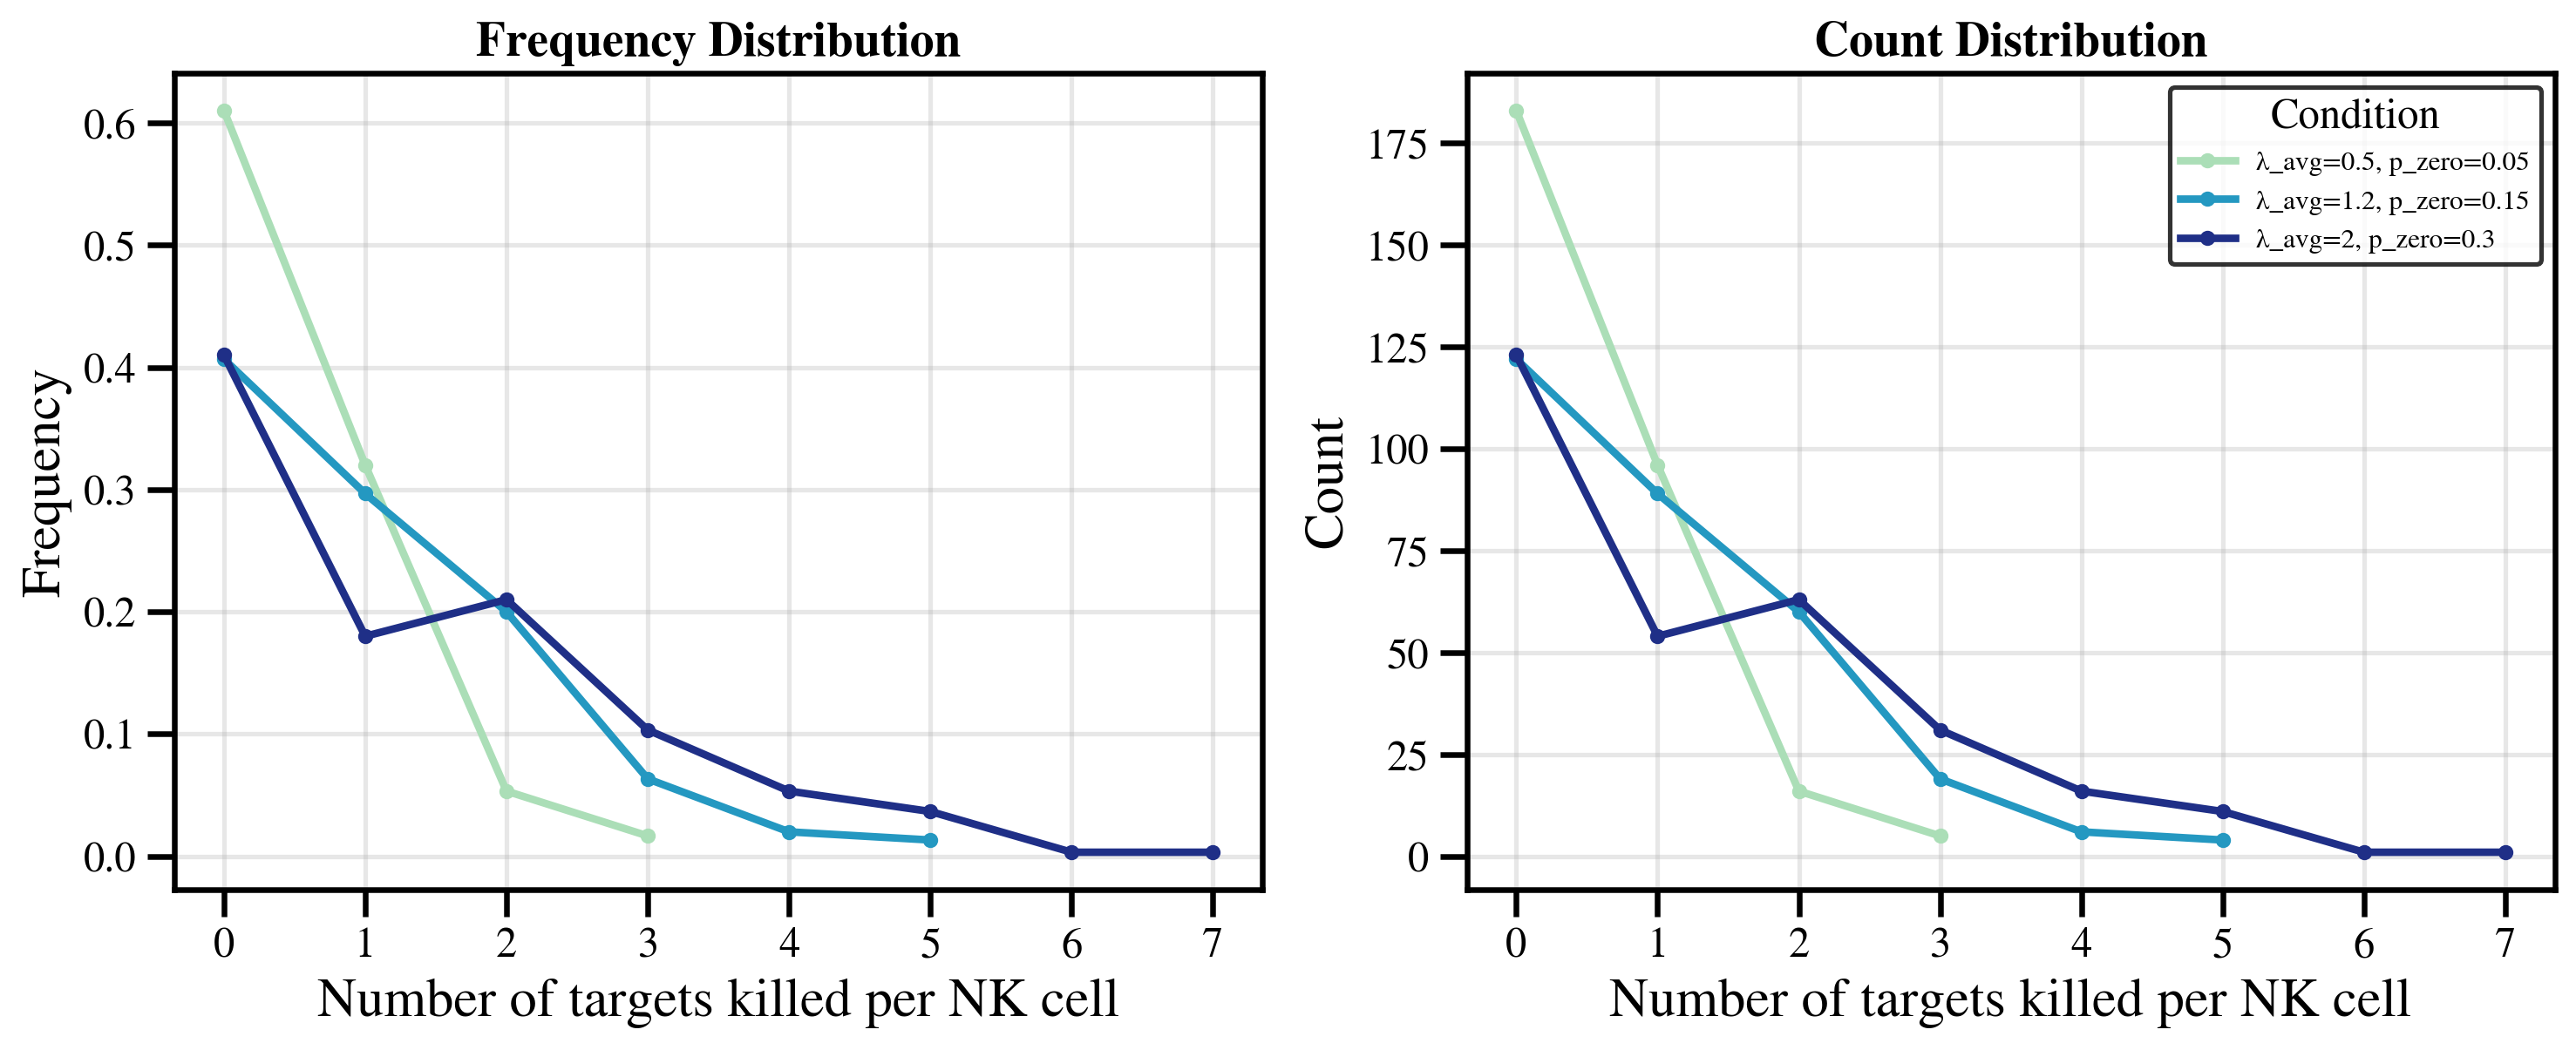

In [32]:
conditions = [
    f"λ_avg={lambda_list[i]}, p_zero={p_zero_list[i]}" 
    for i in range(len(lambda_list))
]

cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond_name in enumerate(conditions):
    colour = colors[i]
    
    kills = experiment[i].get_summary()['kills']
    n_cells = len(kills)
    max_kills = int(kills.max())
    counts = np.bincount(kills, minlength=max_kills + 1)
    freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
    x = np.arange(len(counts))
    
    ax_freq.plot(x, freq, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)
    ax_count.plot(x, counts, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)

ax_freq.set_title("Frequency Distribution", fontweight='bold')
ax_count.set_title("Count Distribution", fontweight='bold')
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")

for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title="Condition", frameon=True, edgecolor='black', loc='upper right', fontsize=9)
plt.tight_layout()
# plt.savefig("./synthetic_data_plots.pdf", dpi=500, bbox_inches="tight")
plt.show()


## Bayesian Inference

In [33]:
def inference_one_zip(kills_per_cell, draws=3000, tune=3000, chains=4, seed=None):
    N = np.asarray(kills_per_cell, dtype=int)

    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-1.0, upper=1.0)
        mu_lambda = pm.Deterministic("mu_lambda", 10.0 ** eta)
        p_zero = pm.Beta("p_zero", alpha=1.0, beta=1.0)
        pm.ZeroInflatedPoisson("kills", psi=1-p_zero, mu=mu_lambda, observed=N)
        idata = pm.sample(
            draws=draws, tune=tune, chains=chains, target_accept=0.95, random_seed=seed
        )

    return idata

def inference_all(experiment, labels=None,
    draws=3000, tune=3000, chains=4, seed=None,
):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]

    out = []
    for i in tqdm(range(len(experiment))):
        current_seed = seed + i if seed is not None else None
        idata = inference_one_zip(
            kills_per_cell=experiment[i].get_summary()['kills'],
            draws=draws, tune=tune, chains=chains, seed=current_seed
            )
        out.append((labels[i], idata))
    return out

In [34]:
conditions = [
    f"λ_avg={lambda_list[i]}, p_zero={p_zero_list[i]}" 
    for i in range(len(lambda_list))
]

ground_truth_values = {}
for i, cond_label in enumerate(conditions):
    ground_truth_values[cond_label] = {
        "mu_lambda": experiment[i].kill_lambda,
        "p_zero": experiment[i].p_zero
    }   


idatas = inference_all(
    experiment=list(experiment.values()),
    labels=conditions,
    draws=4000,
    tune=2000,
    chains=4,
)

  0%|          | 0/3 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, p_zero]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, p_zero]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 3 seconds.
 33%|███▎      | 1/3 [00:04<00:08,  4.19s/it]Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, p_zero]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, p_zero]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 3 seconds.
 67%|██████▋   | 2/3 [00:08<00:04,  4.27s/it]Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, p_zero]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, p_zero]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 3 seconds.
100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23139/2437408868.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


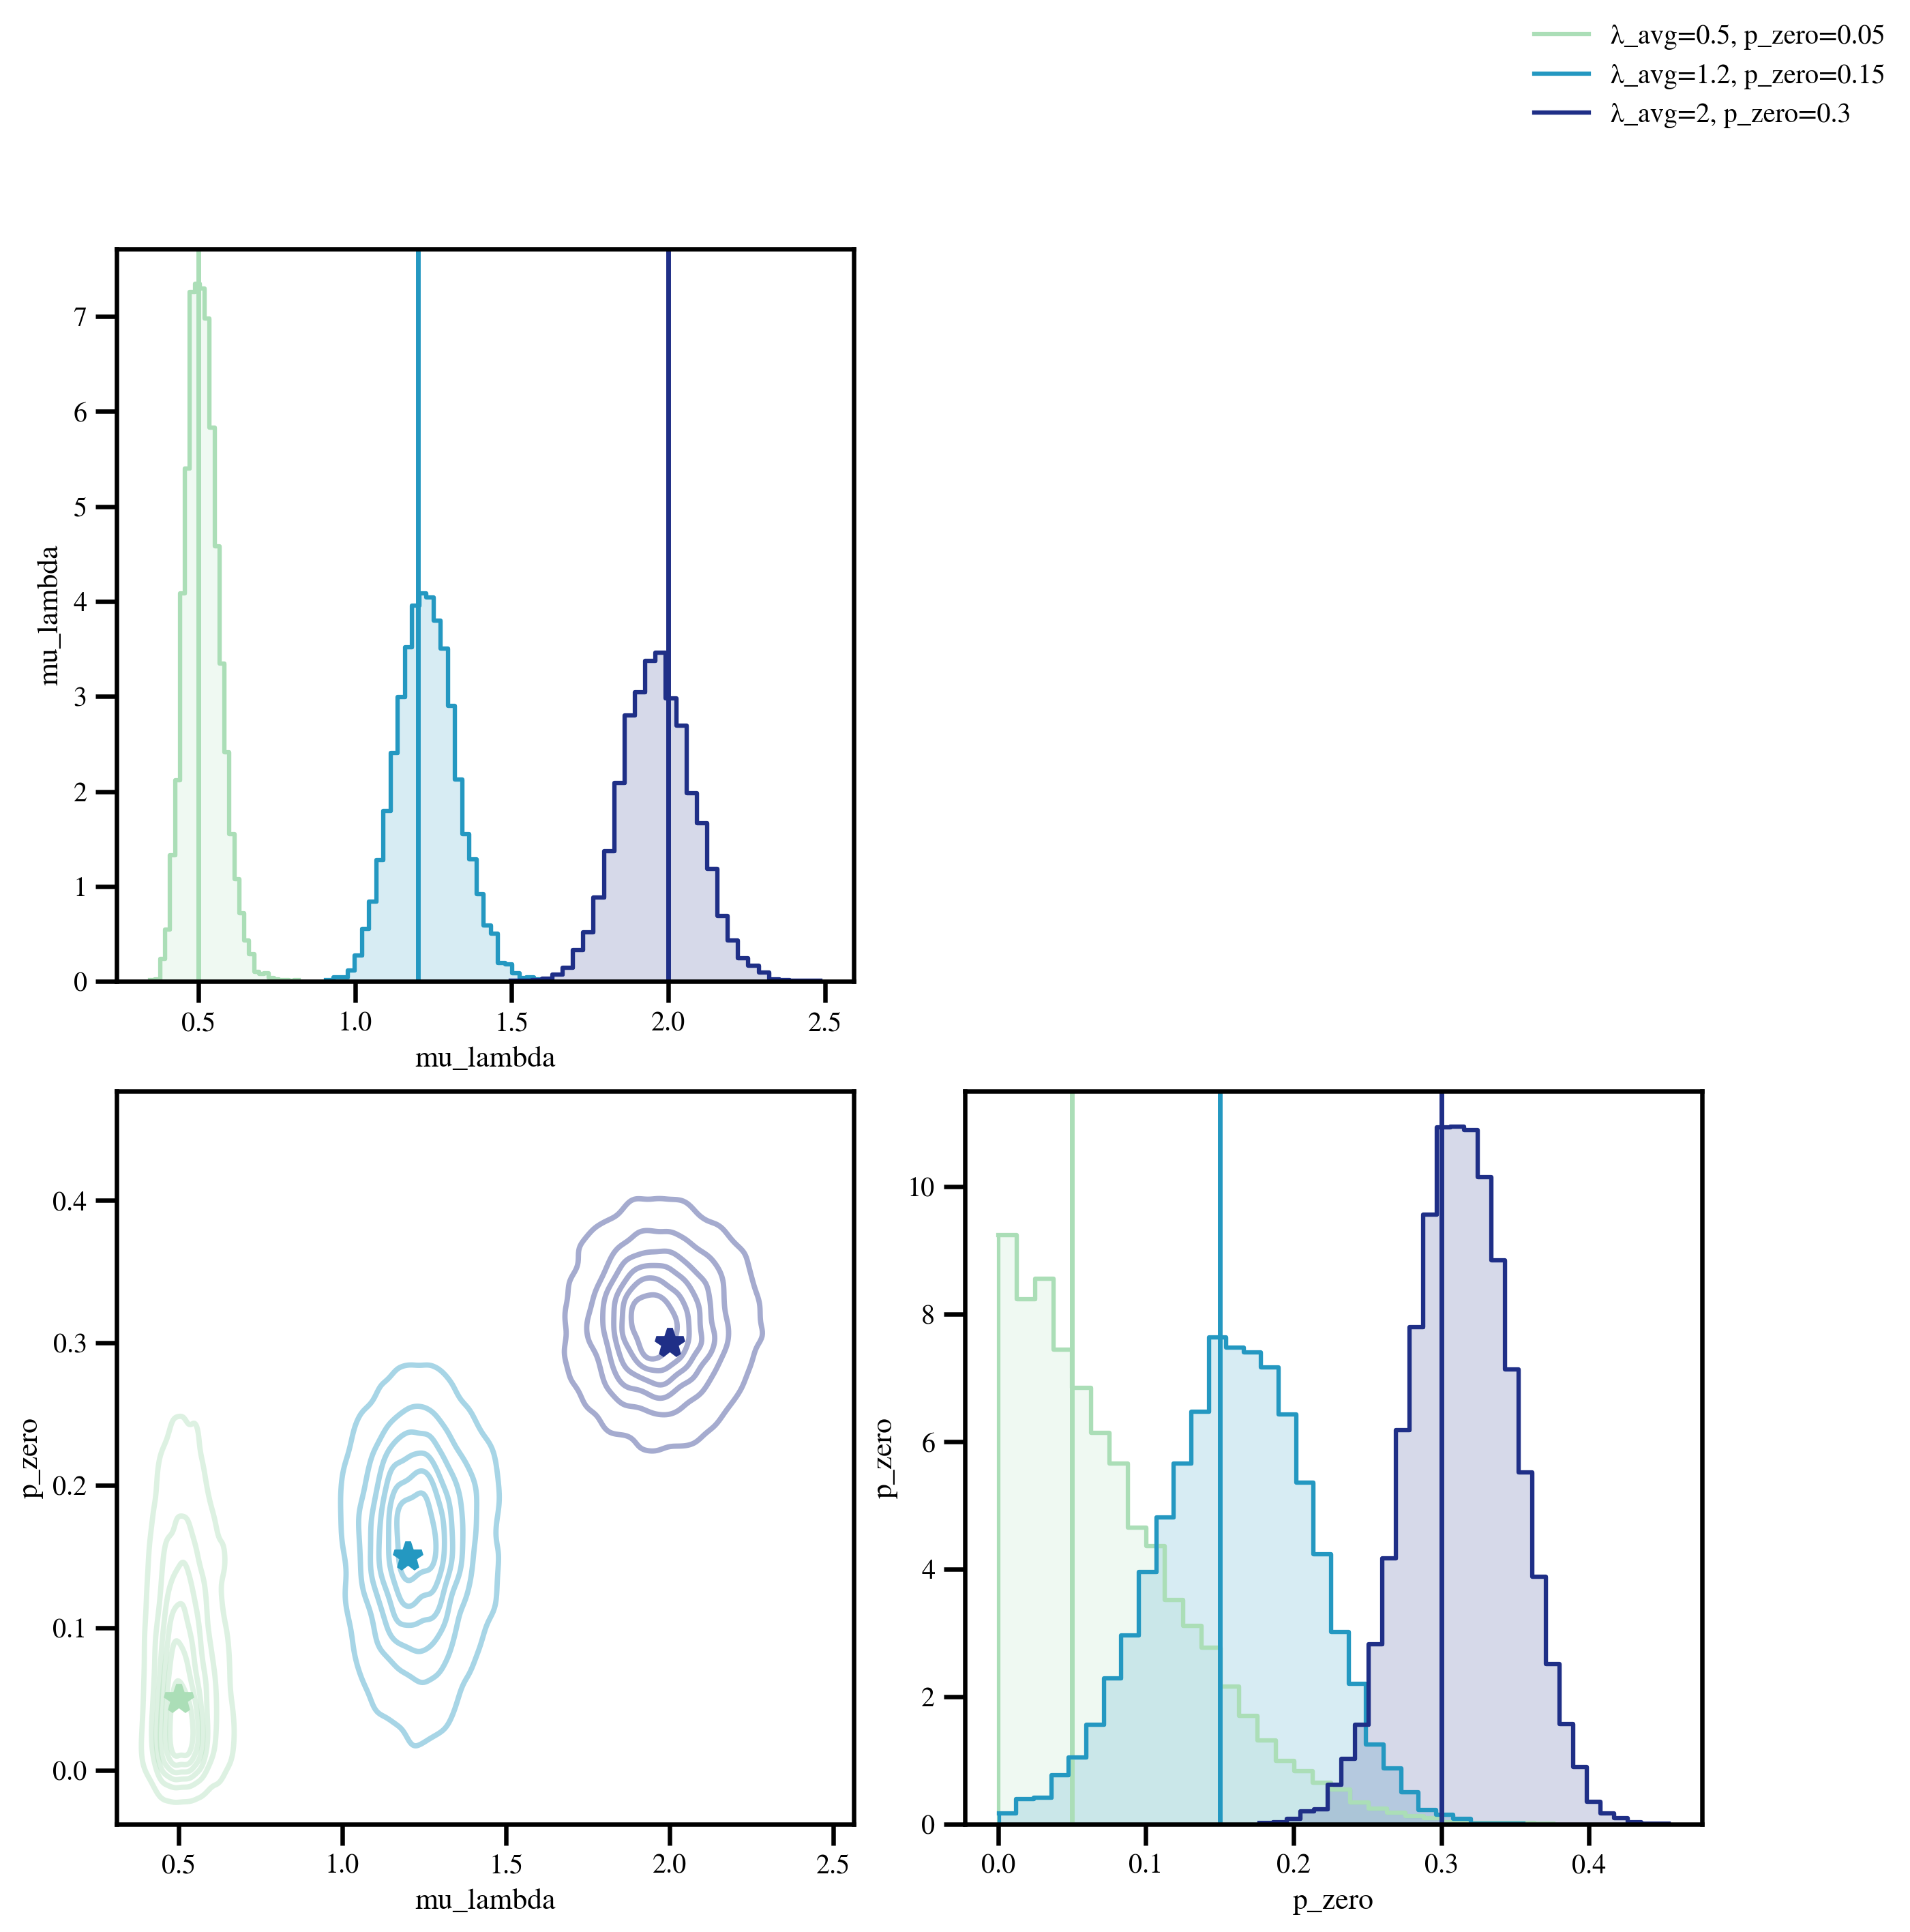

In [35]:
def plot_joint_posteriors(
    idatas,
    ground_truth=None,
    parameters=None,
    hdi_prob=0.95,
    sample_size=200000,
    save_pdf=False,
    diagonal_style = "hist", # "kde" or "hist",
    marginal_style = "circle", # "pixel" or "circle",
    pdf_path="joint_posteriors.pdf",
    cmap_name="YlGnBu",
    point_size=3,
    font_scale=0.7,
):
    sns.set_context("talk", font_scale=font_scale)
    cmap = plt.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0.3, 0.9, len(idatas)))
    label_to_df = {}
    for label, idata in idatas:
        posterior = idata.posterior
        if parameters is None:
            parameters = [v for v in posterior.data_vars if posterior[v].ndim <= 2]
        df = pd.DataFrame()
        for p in parameters:
            vals = posterior[p].stack(sample=("chain", "draw")).values.ravel()
            if len(vals) > sample_size:
                vals = np.random.choice(vals, sample_size, replace=False)
            df[p] = vals
        df["label"] = label
        label_to_df[label] = df
    npar = len(parameters)
    fig = plt.figure(figsize=(6 * npar, 6 * npar), dpi = 250)
    gs = gridspec.GridSpec(npar, npar, wspace=0.15, hspace=0.15)
    gaxes = np.empty((npar, npar), dtype=object)
    for irow, rowpar in enumerate(parameters):
        for icol, colpar in enumerate(parameters):
            ax = plt.subplot(gs[irow, icol])
            gaxes[irow, icol] = ax
            if icol > irow:
                ax.axis("off")
                continue
            for color, (label, df) in zip(colors, label_to_df.items()):
                if icol == irow:
                    if diagonal_style == "kde":
                        sns.kdeplot(
                            df[rowpar], ax=ax, fill=True, color=color,
                            alpha=0.2, linewidth=1.5, label=label if irow == 0 else None,
                        )
                    elif diagonal_style == "hist":
                        vals = df[rowpar].dropna().values
                        sns.histplot(
                            vals, bins=30, stat="density", kde=False,
                            ax=ax, color=color, alpha=0.18,
                            element="step", fill=True,
                        )
                        sns.histplot(
                            vals, bins=30, stat="density", kde=False,
                            ax=ax, color=color, alpha=1.0,
                            element="step", fill=False,
                            linewidth=1.8, label=label if irow == 0 else None,
                        )
                        # lo, hi = az.hdi(vals, hdi_prob=hdi_prob)
                        # ax.axvspan(lo, hi, color=color, alpha=0.08, linewidth=0)
                        # ax.axvline(lo, color=color, linestyle="--", linewidth=1)
                        # ax.axvline(hi, color=color, linestyle="--", linewidth=1)
                        # mean = np.mean(vals)
                        # ax.axvline(mean, color=color, linestyle="-", linewidth=1, alpha=0.9)
                    if ground_truth is not None and label in ground_truth and rowpar in ground_truth[label]:
                        ax.axvline(ground_truth[label][rowpar], color=color, linestyle='-', linewidth=2)
                
                else:
                    if marginal_style == "circle":
                        sns.kdeplot(
                            x=df[colpar], y=df[rowpar], ax=ax, fill=False, color=color, alpha=0.4, levels=7,
                        )
                    if marginal_style == "pixel":
                        sns.histplot(
                            x=df[colpar], y=df[rowpar], bins=10, pthresh=0.01, cmap=cmap_name, cbar=False, ax=ax,
                        )
                    if ground_truth and label in ground_truth:
                        if colpar in ground_truth[label] and rowpar in ground_truth[label]:
                            ax.plot(ground_truth[label][colpar], ground_truth[label][rowpar],
                                    marker='*', color=color, markersize=12, markeredgewidth=2.5, linestyle='None')
            if icol == irow:
                ax.set_xlabel(rowpar)
                ax.set_ylabel(rowpar)
            else:
                if irow == npar - 1:
                    ax.set_xlabel(colpar)
                else:
                    ax.set_xticklabels([])
                if icol == 0 and irow != 0:
                    ax.set_ylabel(rowpar)
                else:
                    ax.set_yticklabels([])
    handles, labels = gaxes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right", frameon=False)
    plt.tight_layout()
    if save_pdf:
        plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved joint posterior plot: {pdf_path}")
    plt.show()

plot_joint_posteriors(
    idatas,
    ground_truth=ground_truth_values,
    parameters=["mu_lambda", "p_zero"],
    hdi_prob=0.95,
    sample_size=10000,
    # save_pdf=True,
    # pdf_path="joint_posteriors_8000cells_ana.pdf"
)   